### Experiment: skip window 2048 characters, max skips 5/10/15, max amb level 1

#### Max 5 skips:
- Parse errors: 3.54% -> 4.03%
- Error counts avg: 1.37 -> 1.68
- Error size avg: 412 -> 377
- Slow parses (x10 parse time): 0.41% -> 0.25%
- New successful recoveries < 2048: 92.07% (2.83% unsuccessful)
- Old successful recoveres < 25%: 81.20% (13.91% unsuccessful)
- Total time to run tests: 48 hour -> 32 hour
- "Problematic" PreferAvoid test duration: 2500 ms -> 6 ms (was 17 hour before max amb filtering :-))

Note: as "max skip window" and "succesful recovery limit" are currently both set to 2048, the only reasons for
unsuccesful recoveries are:
- Continuation token that starts just before the 2048 boundery and crosses it
- Multiple errors that together add up to more than 2048 characters

#### max 10 skips:
- Parse errors 4.03 -> 4.13
- Error count average: 1.68 -> 1.54
- Error size average: 377 -> 373
- Slow parses: 0.25% -> 0.25%
- Successful recoveries: 92.07% -> 92.01%

#### max 15 skips:
- Parse erorers -> 4.03 -> 4.25
- Error count avg: 1.68 -> 1.45
- Error size avg: 377 -> 396
- Slow parses: 0.25% -> 0.19%
- Succesfull recoveries: 92.07% -> 91.87%


Prepare data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
import os

sns.set_theme()

statDir = "D:/stats"

def downloadData(host="test", syntax="rascal", testSet="main", label="", minSize=0, maxSize=10240, skipLimit=3, skipWindow=2048, recovLimit=50, sampleWindow=1, seed=0, countNodes=True):
    dir = "stats/" + syntax + "/" + testSet
    os.makedirs(statDir + "/" + dir, exist_ok=True)
    path = dir + "/stats-" + label + "-" + str(minSize) + "-" + str(maxSize) + ",skip-limit=" + str(skipLimit) + ",skip-window=" + str(skipWindow) + ",recovery-limit=" + str(recovLimit) + ",sample-window=" + str(sampleWindow) + ",seed=" + str(seed) + (",count-nodes" if countNodes else "") +".txt"
    
    os.makedirs(statDir + "/cache/" + dir, exist_ok=True)
    cachedFile = statDir + "/cache/" + path
    if (not os.path.isfile(cachedFile + ".gz")):
        print("Downloading file " + path + " from " + host)
        cmd = "scp root@" + host + ":~/" + path + " " + cachedFile
        print("Command: " + cmd)
        result = os.system(cmd)
        if (result != 0):
            raise Exception("Error downloading file: " + str(result))
        os.system("gzip " + cachedFile)
    else:
        print("Using cached file: " + cachedFile)

    df = readData(cachedFile + ".gz")
    df["skipLimit"] = skipLimit
    df["skipWindow"] = skipWindow
    df["recoveryLimit"] = recovLimit
    return df
    

def readData(file):
    dtypes={
        'nodes':float
    }

    if (file.startswith(statDir)):
        path = file
    else:
        path = statDir + "/" + file
    if (file.endswith(".gz")):
        fd = gzip.open(path, 'rb')
    else:
        fd = open(path, 'rb')

    data = pd.read_csv(fd, dtype=dtypes)
    fd.close()

    recovered = data[data["result"] == "recovery"].sort_values("size")
    maxSize = recovered["size"].max()
    range = np.arange(0, maxSize+1024, 1024)
    recovered["bsize"] = pd.cut(recovered["size"], range, labels=range[1:])
    recovered["durationRatioFloat"] = recovered["durationRatio"] / 100.0

    return recovered


largeData = readData('stats-todo-reset-10240-102400,max-recovery-attempts=50,max-recovery-tokens=3,sample-window=1,seed=0.txt')
print("Large file duration:")
print(largeData["duration"].describe())
print("Large file duration ratio:")
print(largeData["durationRatio"].describe())

smallData = readData('stats-todo-reset-0-10240,max-recovery-attempts=50,max-recovery-tokens=3,sample-window=1,seed=0.txt.gz')
print("Small file duration:")
print(smallData["duration"].describe())
print("Small file duration ratio:")
print(smallData["durationRatio"].describe())

#recovered_old = readData("benchmark-stats-2025-04-29-flattener-amb-filter-rascal-0-10240maxamb-1.txt.gz")
recovered_old = readData("benchmark-stats-2025-05-10-skip-window-rascal-0-10240skip-5-2048.txt.gz")
recovered_old["recoveryLimit"] = 200
#recovered = stats.readData("benchmark-stats-2025-04-19-parent-amb-3-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-2-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-any-3-rascal-0-10240.txt.gz")

# Read data at different pruning levels
recoveryLimits = [10,30,50]
successPcts = [89.7, 92.0, 92.18, 92.22]
recovered = []
descriptions = []
for recoveryLimit in recoveryLimits:
    df = downloadData(label="recov-limit", recovLimit=str(recoveryLimit))
    recovered.append(df)
    descriptions.append("recovLimit=" + str(recoveryLimit) + ", success=" + str(successPcts[recoveryLimits.index(recoveryLimit)]) + "%")

recovered.append(recovered_old)
descriptions.append("recovLimit=unlimited, success=92.22%")
count = len(recovered)

Duration:
count    200422.000000
mean        184.488444
std         111.068859
min          63.000000
25%         114.000000
50%         165.000000
75%         219.000000
max        1371.000000
Name: duration, dtype: float64
Duration ratio:
count    200422.00000
mean        132.34146
std          46.04632
min          35.00000
25%         108.00000
50%         125.00000
75%         149.00000
max         745.00000
Name: durationRatio, dtype: float64
Command: scp root@test:~/stats/rascal/main/stats-recov-limit-0-10240,skip-limit=3,skip-window=2048,recovery-limit=10,sample-window=1,seed=0,count-nodes.txt D:/stats/cache/stats/rascal/main/stats-recov-limit-0-10240,skip-limit=3,skip-window=2048,recovery-limit=10,sample-window=1,seed=0,count-nodes.txt


Exception: Error downloading file: 1

In [ ]:
qualityDataPerRecovLimit = pd.DataFrame({
    "recoveryLimit": ["10", "30", "50", "200"],
    "successPct": [89.7, 92.0, 92.18, 92.22],
    "errorLength": [342.77, 342.14, 348.15, 352.94]
})


### Visualize the recovery duration per file size bucket.

duration of recovLimit=10, success=89.7%
count    856835.000000
mean         50.971157
std          37.522025
min           0.000000
25%          21.000000
50%          43.000000
75%          73.000000
max         423.000000
Name: duration, dtype: float64
duration of recovLimit=30, success=92.0%
count    881223.000000
mean         52.418295
std          41.459601
min           0.000000
25%          22.000000
50%          44.000000
75%          74.000000
max         817.000000
Name: duration, dtype: float64
duration of recovLimit=50, success=92.18%
count    885066.000000
mean         52.753099
std          42.137304
min           0.000000
25%          22.000000
50%          44.000000
75%          75.000000
max         794.000000
Name: duration, dtype: float64
duration of recovLimit=unlimited
count    885872.000000
mean         52.667929
std          41.371108
min           0.000000
25%          22.000000
50%          44.000000
75%          75.000000
max        1992.000000
Name: duration

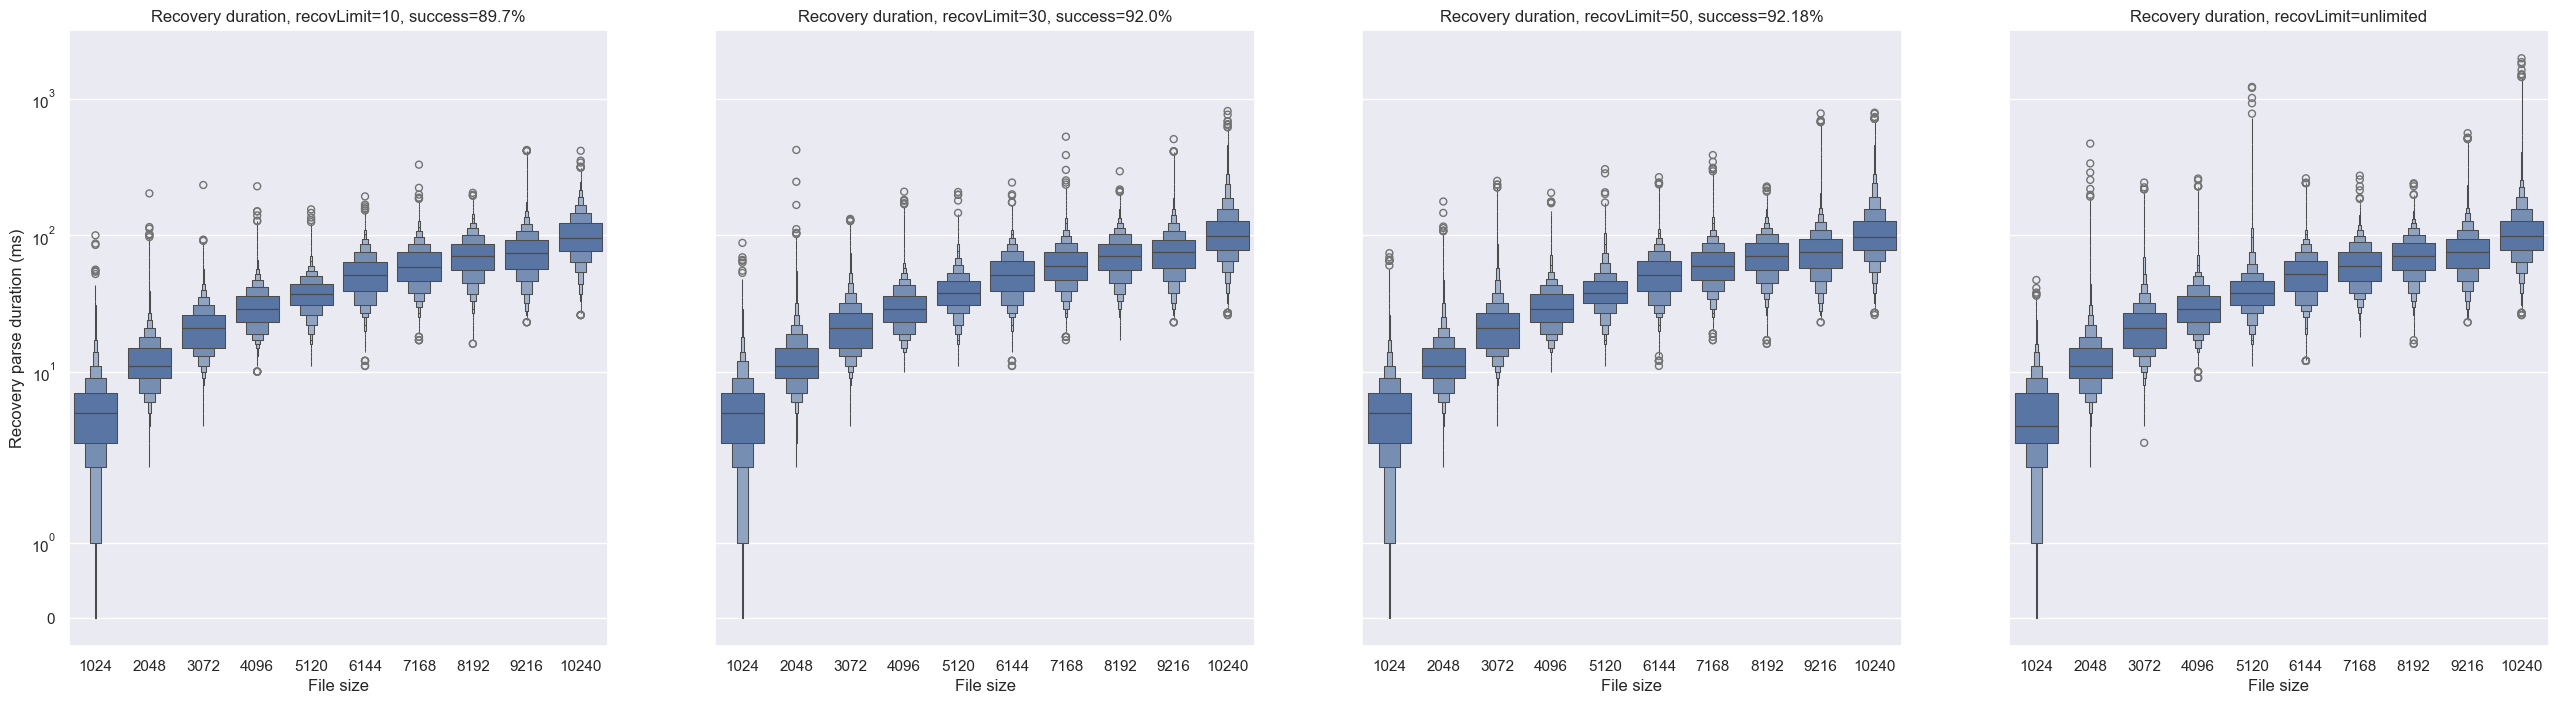

In [51]:
durationFig, durationAx = plt.subplots(1, count, figsize=(count*8, 8), sharey=True)
durationAx[0].set_yscale('symlog')

for i in range(0, count):
    description = descriptions[i]
    print("duration of " + description)
    print(recovered[i]["duration"].describe())

    sns.boxenplot(
        data=recovered[i],
        x="bsize", y="duration",
        width_method="exponential",
        ax = durationAx[i]
    )
    durationAx[i].set_title("Recovery duration, " + description)
    durationAx[i].set_xlabel("File size")
    durationAx[i].set_ylabel("Recovery parse duration (ms)")

plt.show(durationFig)

### Node distribution per file size

nodes of recovLimit=10, success=89.7%
count    8.568350e+05
mean     2.548534e+04
std      3.060939e+04
min      3.700000e+01
25%      1.092900e+04
50%      2.101600e+04
75%      3.263700e+04
max      7.311281e+06
Name: nodes, dtype: float64
nodes of recovLimit=30, success=92.0%
count    8.812230e+05
mean     2.796670e+04
std      8.292749e+04
min      3.700000e+01
25%      1.105800e+04
50%      2.133200e+04
75%      3.310200e+04
max      1.985309e+07
Name: nodes, dtype: float64
nodes of recovLimit=50, success=92.18%
count    8.850660e+05
mean     2.848714e+04
std      8.669850e+04
min      3.700000e+01
25%      1.108500e+04
50%      2.138450e+04
75%      3.318700e+04
max      1.985309e+07
Name: nodes, dtype: float64
nodes of recovLimit=unlimited
count    8.858720e+05
mean     2.190667e+04
std      3.015650e+04
min      3.700000e+01
25%      9.935000e+03
50%      1.880700e+04
75%      2.946600e+04
max      7.876275e+06
Name: nodes, dtype: float64


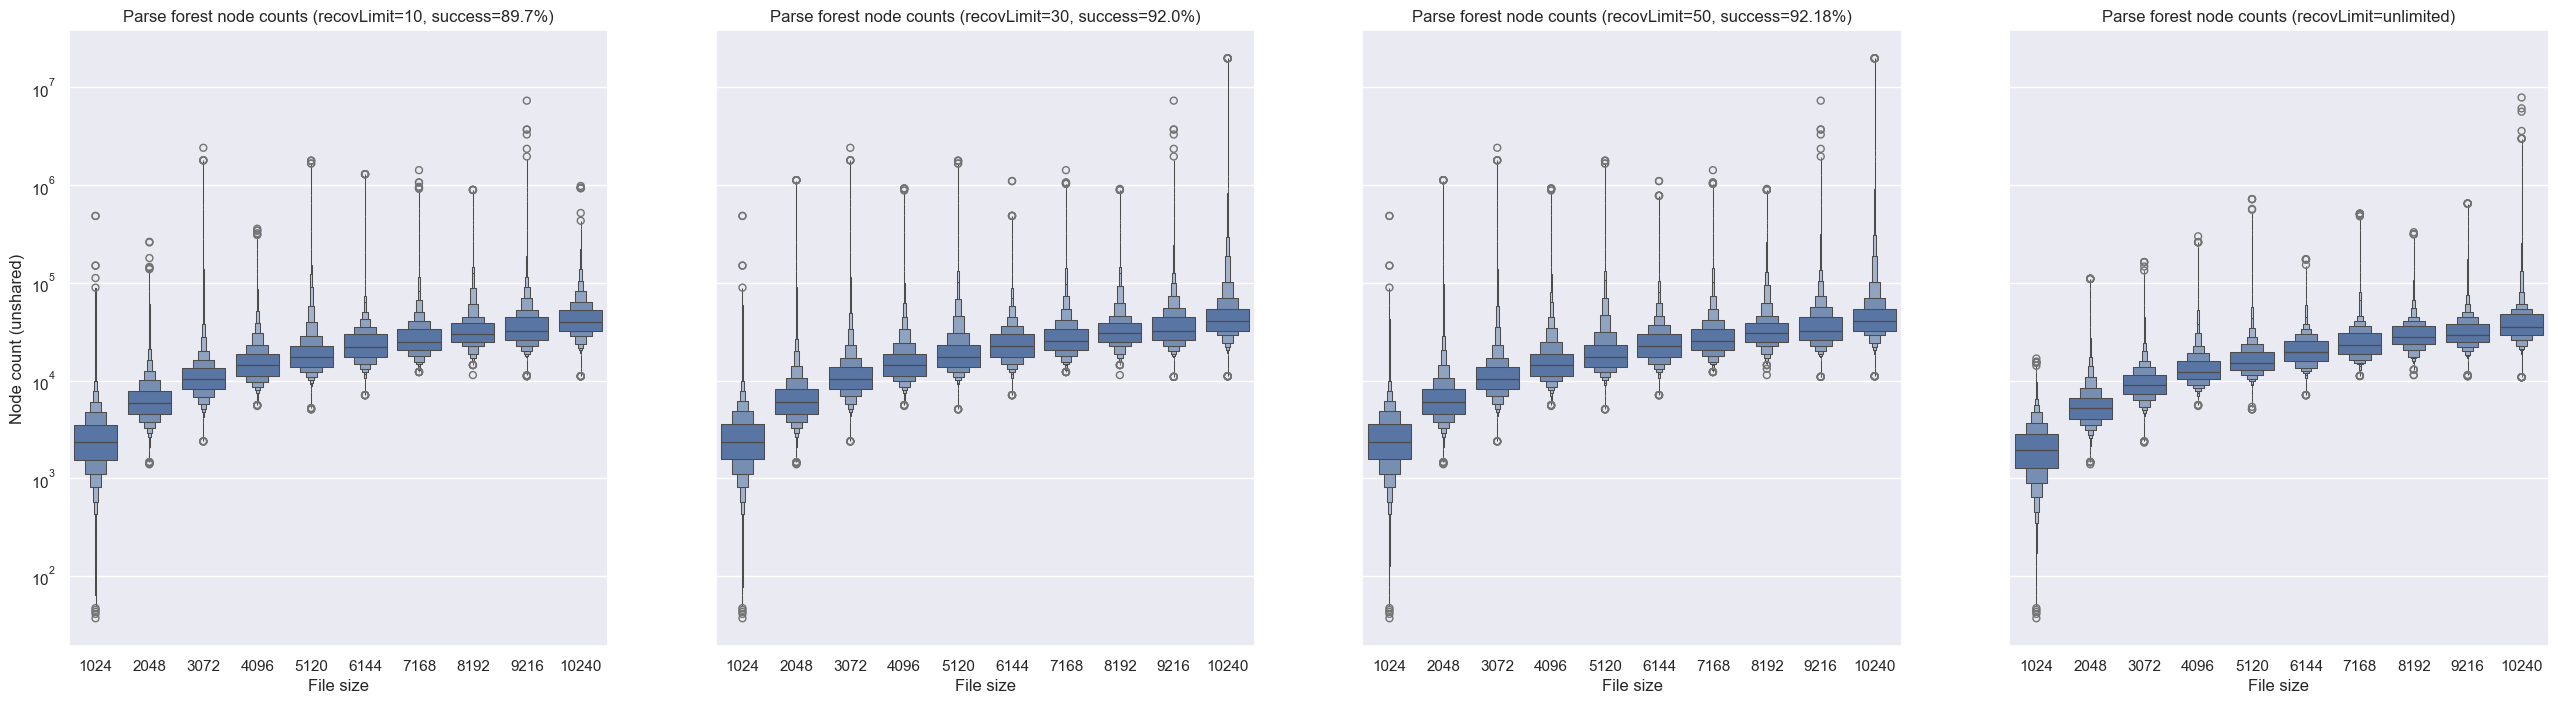

In [52]:
nodeFig, nodeAx = plt.subplots(1, count, figsize=(8*count, 8), sharey=True)
nodeAx[0].set_yscale('symlog')

for i in range(0, count):
    description = descriptions[i]
    print("nodes of " + description)
    print(recovered[i]["nodes"].describe())

    sns.boxenplot(
        data=recovered[i],
        x="bsize", y="nodes",
        width_method="exponential",
        ax=nodeAx[i]
    )

    nodeAx[i].set_title("Parse forest node counts (" + description + ")")
    nodeAx[i].set_xlabel("File size")
    nodeAx[i].set_ylabel("Node count (unshared)")


#sns.violinplot(
#    data=recovered[2],
#    x="bsize", y="nodes",
#    density_norm="width",
#    ax=ax2
#)

plt.show(nodeFig)

### Parse time ratio vs file size

count    856835.000000
mean        175.271707
std          79.259885
min           0.000000
25%         129.000000
50%         158.000000
75%         200.000000
max        5500.000000
Name: durationRatio, dtype: float64


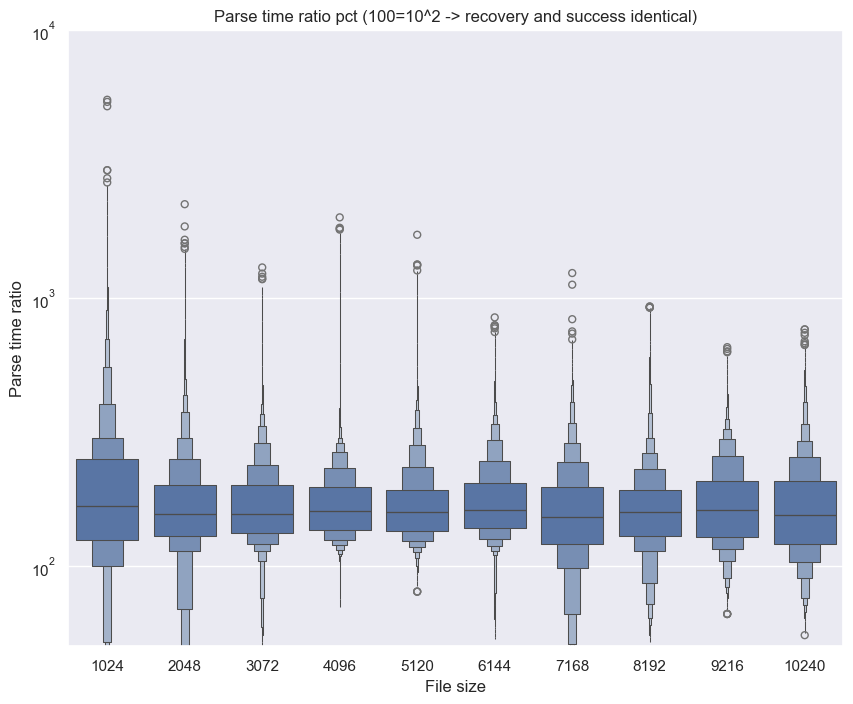

In [53]:
print(recovered[0]["durationRatio"].describe())

durationRatioFig, durationRatioAx = plt.subplots(figsize=(10, 8))

sns.boxenplot(
    data=recovered[0],
    x="bsize", y="durationRatio",
    width_method="exponential",
    ax=durationRatioAx
)

durationRatioAx.set_yscale('symlog')

durationRatioAx.set_title("Parse time ratio pct (100=10^2 -> recovery and success identical)")
durationRatioAx.set_xlabel("File size")
durationRatioAx.set_ylabel("Parse time ratio")
durationRatioAx.set_ylim(50, 10000)
plt.show(durationRatioFig)


### Node count ratio vs file size

count    856835.000000
mean        172.351115
std         201.016982
min          20.000000
25%         108.000000
50%         146.000000
75%         184.000000
max       33481.000000
Name: nodeRatio, dtype: float64


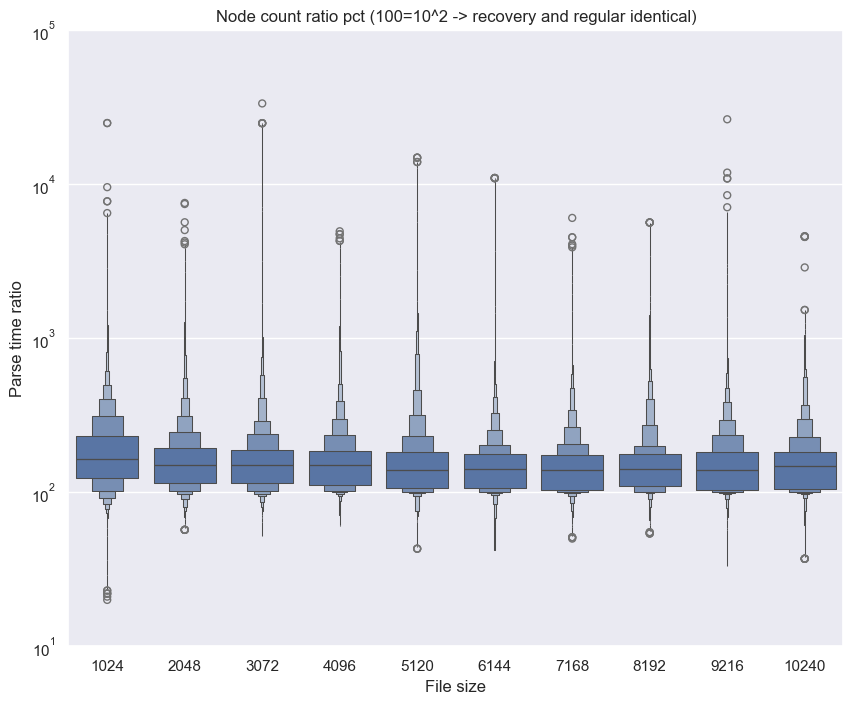

In [9]:
print(recovered[0]["nodeRatio"].describe())

nodeRatioFig, nodeRatioAx = plt.subplots(figsize=(10, 8))

sns.boxenplot(
    data=recovered[0],
    x="bsize", y="nodeRatio",
    width_method="exponential",
    ax=nodeRatioAx
)

nodeRatioAx.set_yscale('symlog')
nodeRatioAx.set_title("Node count ratio pct (100=10^2 -> recovery and regular identical)")
nodeRatioAx.set_xlabel("File size")
nodeRatioAx.set_ylabel("Parse time ratio")
nodeRatioAx.set_ylim(10, 100000)

plt.show(nodeRatioFig)



### Error recovery duration histogram

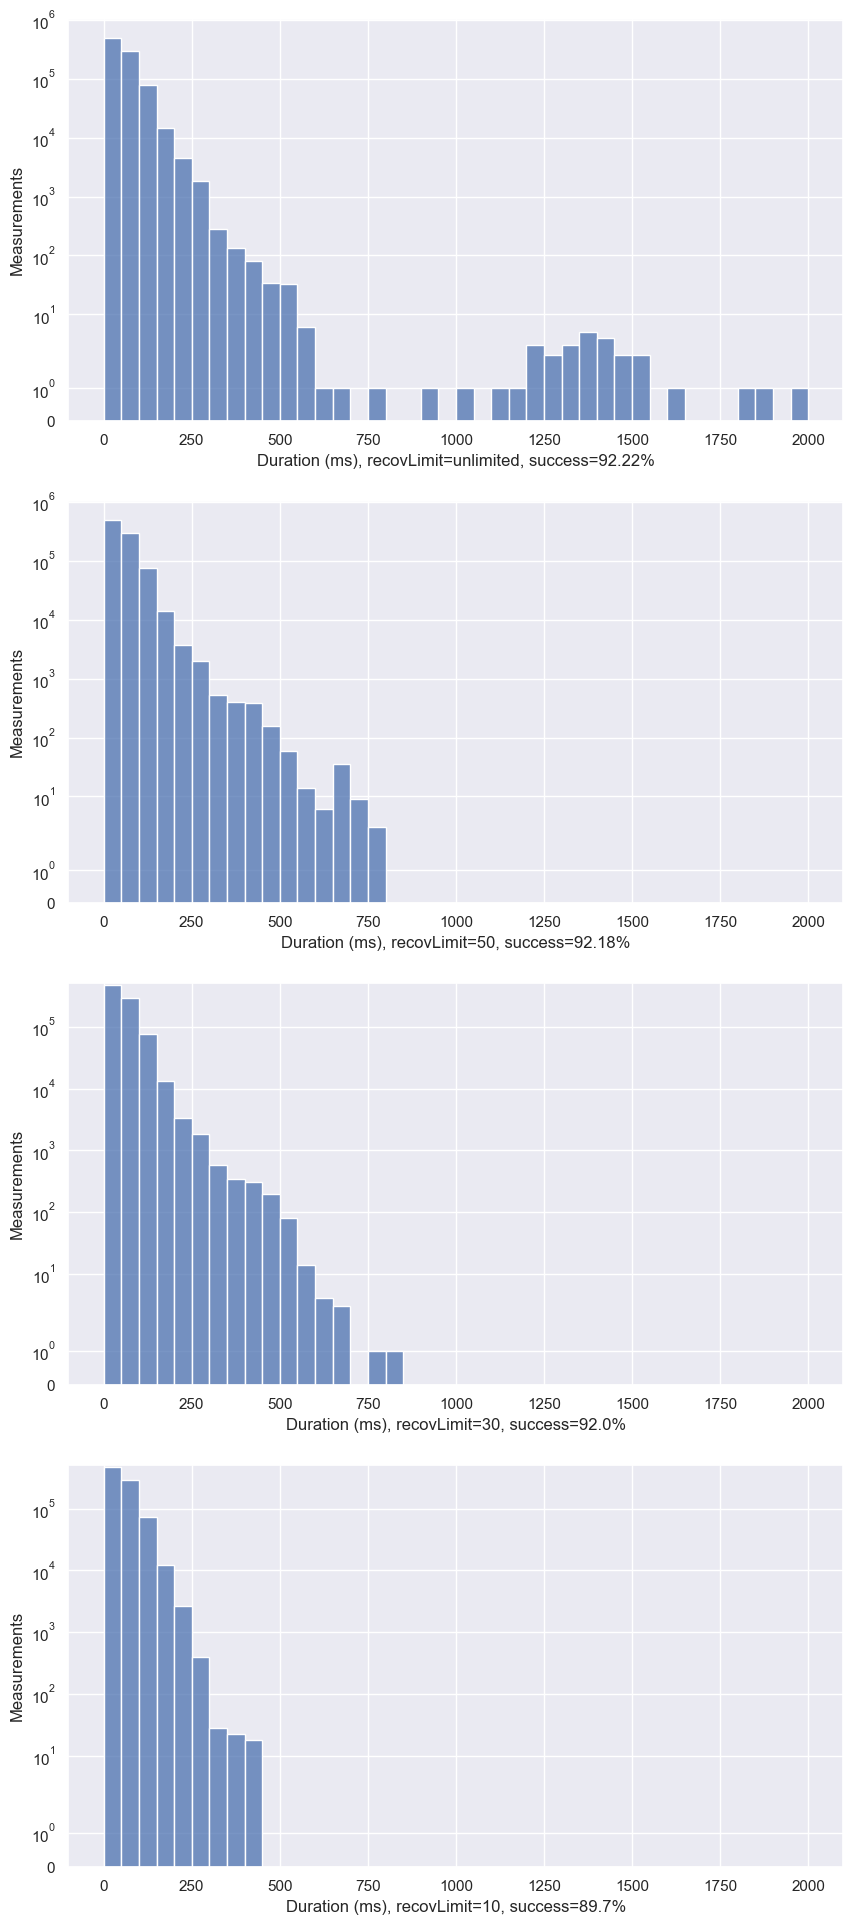

In [64]:
durationHistFig, durationHistAx = plt.subplots(4, 1, figsize=(10, 24))

histBins = np.arange(0, 80, 1)
for i in range(0, count):
    sns.histplot(
        data=recovered[i],
        x="duration", stat="count",
        bins=np.arange(0, 2050, 50),
        ax=durationHistAx[3-i]
    )

    durationHistAx[i].set_yscale('symlog')
    durationHistAx[i].set_xlabel("Duration (ms), " + descriptions[3-i])
    durationHistAx[i].set_ylabel("Measurements")

plt.show(durationHistFig)

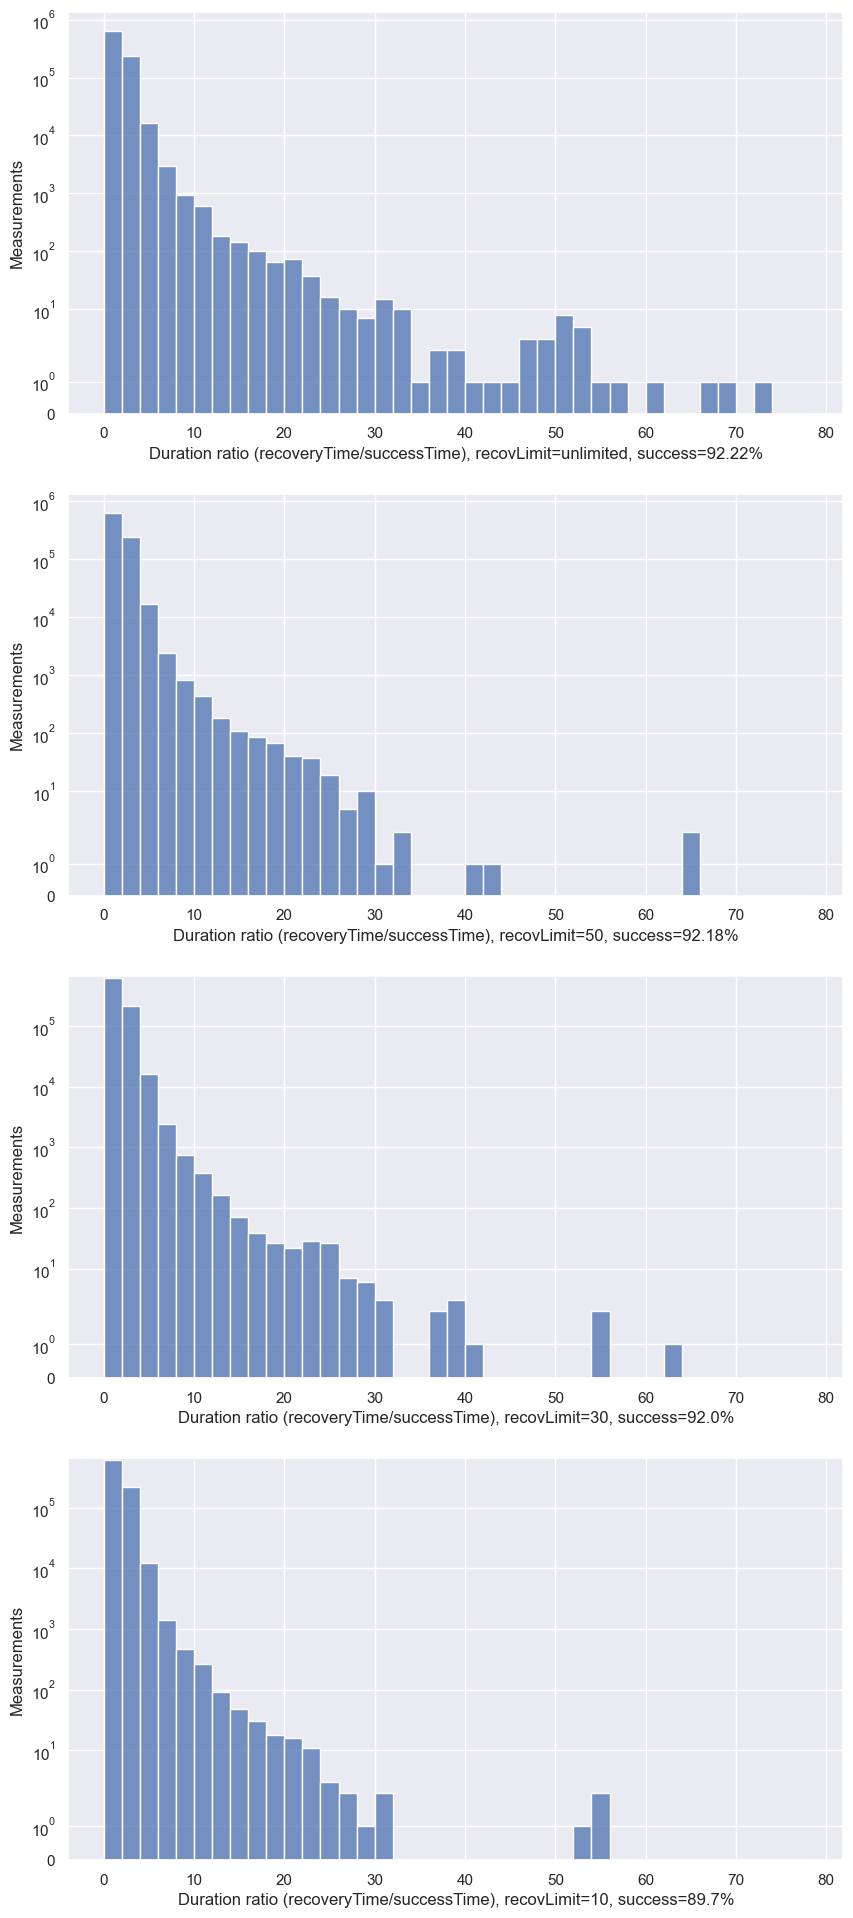

In [66]:
durationRatioHistFig, durationRatioHistAx = plt.subplots(4, 1, figsize=(10, 24))

for i in range(0, count):
    sns.histplot(
        data=recovered[i],
        x="durationRatioFloat", stat="count",
        bins=np.arange(0, 80, 2),
        ax=durationRatioHistAx[3-i]
    )

    durationRatioHistAx[i].set_yscale('symlog')
    durationRatioHistAx[i].set_xlabel("Duration ratio (recoveryTime/successTime), " + descriptions[3-i])
    durationRatioHistAx[i].set_ylabel("Measurements")

#sns.histplot(
#    data=recovered_old,
#    x="durationRatioFloat", stat="count",
#    bins=histBins,
#    ax=durationRatioHistAx[3]
#)

plt.show(durationRatioHistFig)

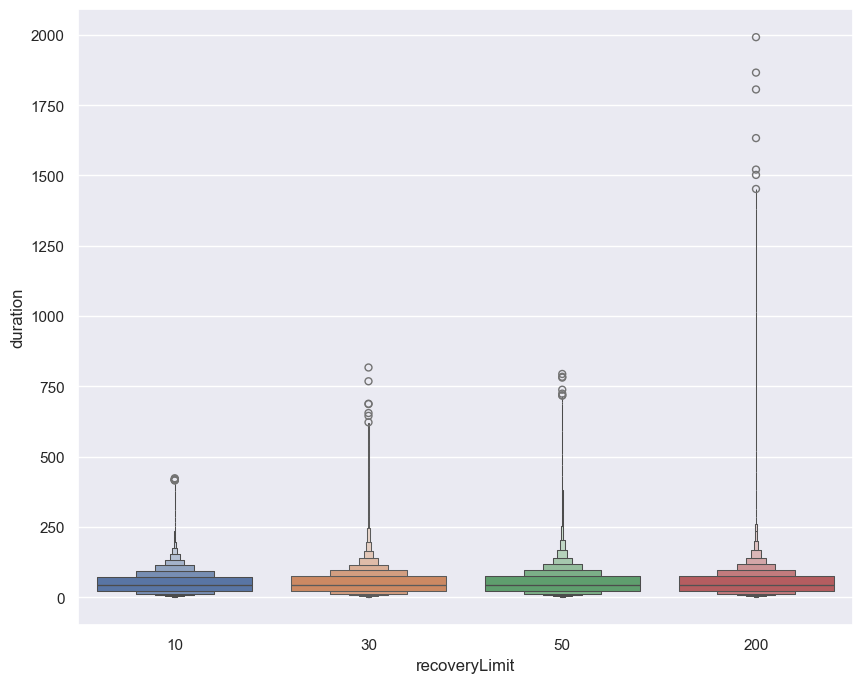

In [63]:
durationPerRecovLimitFig, durationPerRecovLimitAx = plt.subplots(figsize=(10, 8))

sns.boxenplot(
    data=recovered[0],
    x="recoveryLimit", y="duration",
    width_method="exponential",
    ax=durationPerRecovLimitAx
)

sns.boxenplot(
    data=recovered[1],
    x="recoveryLimit", y="duration",
    width_method="exponential",
    ax=durationPerRecovLimitAx
)

sns.boxenplot(
    data=recovered[2],
    x="recoveryLimit", y="duration",
    width_method="exponential",
    ax=durationPerRecovLimitAx
)

sns.boxenplot(
    data=recovered_old,
    x="recoveryLimit", y="duration",
    width_method="exponential",
    ax=durationPerRecovLimitAx
)
'''
successAx=durationPerRecovLimitAx.twinx()
successAx.set_ylim(0, 100)

sns.lineplot(
    data=qualityDataPerRecovLimit,
    x="recoveryLimit", y="successPct",
    ax=successAx
)
'''

plt.show(durationPerRecovLimitFig)